In [1]:
from typing import TYPE_CHECKING, Callable, Optional, Union
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
sys.path.append("/home/tangyao/ovam/ovam")
sys.path.append("/home/tangyao/ovam/ovam/utils")
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
from PIL import Image
# Import the OVAM library
from ovam import StableDiffusionHooker # actually is StableDiffusionHookerSA
from ovam.utils import set_seed, get_device
from ovam.optimize import optimize_embedding
from ovam.utils.dcrf import densecrf
# from diffusers import StableDiffusionPipeline
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, DDPMScheduler, StableDiffusionPipeline, UNet2DConditionModel

if TYPE_CHECKING:
    from ..base.daam_module import DAAMModule



# -----------------------------Prepare model-----------------------------------
# args = parse_args()
pretrained_model_name_or_path="/home/data/huggingface/Pretrained_model_files/sd_v1-4"
pre_unet_path="/home/tangyao/BadT2I/laion_pixel_boya_unet_bsz4_step4_sks"
revision=None
vae = AutoencoderKL.from_pretrained(
        pretrained_model_name_or_path,
        subfolder="vae",
        revision=revision,
        low_cpu_mem_usage=False,
    )
text_encoder = CLIPTextModel.from_pretrained(
        pretrained_model_name_or_path,
        subfolder="text_encoder",
        revision=revision,
        low_cpu_mem_usage=True,
    )
tokenizer = CLIPTokenizer.from_pretrained(
        pretrained_model_name_or_path, subfolder="tokenizer", revision=revision, low_cpu_mem_usage=True,
    )
noise_scheduler = DDPMScheduler.from_pretrained(pretrained_model_name_or_path, subfolder="scheduler",
                                                    low_cpu_mem_usage=False, )
unet = UNet2DConditionModel.from_pretrained(
        pre_unet_path,
        revision=revision,
        low_cpu_mem_usage=False,
    )
# Unet2D conditionModel 可以直接加timestep
pipe = StableDiffusionPipeline.from_pretrained(
            pretrained_model_name_or_path,
            text_encoder=text_encoder,
            vae=vae,
            unet=unet,
            revision=revision,
            low_cpu_mem_usage=False,
        )

device = get_device()
pipe = pipe.to(device)






/home/tangyao/anaconda3/envs/noiseclr/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The config attributes {'dropout': 0.0} were passed to UNet2DConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.
Loading pipeline components...: 100%|██████████| 7/7 [00:02<00:00,  2.73it/s]


In [ ]:

class CLIPTextTransformer(nn.Module):
    def __init__(self, config: CLIPTextConfig):
        super().__init__()
        self.config = config
        embed_dim = config.hidden_size
        self.embeddings = CLIPTextEmbeddings(config)
        self.encoder = CLIPEncoder(config)
        self.final_layer_norm = nn.LayerNorm(embed_dim, eps=config.layer_norm_eps)

    @add_start_docstrings_to_model_forward(CLIP_TEXT_INPUTS_DOCSTRING)
    @replace_return_docstrings(output_type=BaseModelOutputWithPooling, config_class=CLIPTextConfig)
    def forward(
        self,
        input_ids: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.Tensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple, BaseModelOutputWithPooling]:
        r"""
        Returns:

        """
        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        if input_ids is None:
            raise ValueError("You have to specify input_ids")

        input_shape = input_ids.size()
        input_ids = input_ids.view(-1, input_shape[-1])

        hidden_states = self.embeddings(input_ids=input_ids, position_ids=position_ids)

        # CLIP's text model uses causal mask, prepare it here.
        # https://github.com/openai/CLIP/blob/cfcffb90e69f37bf2ff1e988237a0fbe41f33c04/clip/model.py#L324
        causal_attention_mask = _make_causal_mask(input_shape, hidden_states.dtype, device=hidden_states.device)
        # expand attention_mask
        if attention_mask is not None:
            # [bsz, seq_len] -> [bsz, 1, tgt_seq_len, src_seq_len]
            attention_mask = _expand_mask(attention_mask, hidden_states.dtype)

        encoder_outputs = self.encoder(
            inputs_embeds=hidden_states,
            attention_mask=attention_mask,
            causal_attention_mask=causal_attention_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        last_hidden_state = encoder_outputs[0]
        last_hidden_state = self.final_layer_norm(last_hidden_state)

        # text_embeds.shape = [batch_size, sequence_length, transformer.width]
        # take features from the eot embedding (eot_token is the highest number in each sequence)
        # casting to torch.int for onnx compatibility: argmax doesn't support int64 inputs with opset 14
        pooled_output = last_hidden_state[
            torch.arange(last_hidden_state.shape[0], device=last_hidden_state.device),
            input_ids.to(dtype=torch.int, device=last_hidden_state.device).argmax(dim=-1),
        ]

        if not return_dict:
            return (last_hidden_state, pooled_output) + encoder_outputs[1:]

        return BaseModelOutputWithPooling(
            last_hidden_state=last_hidden_state,
            pooler_output=pooled_output,
            hidden_states=encoder_outputs.hidden_states,
            attentions=encoder_outputs.attentions,
        )

def trans_forward(
    self,
    trigger_ids: Optional[torch.Tensor]=  None,
    input_ids: Optional[torch.Tensor] = None,
    attention_mask: Optional[torch.Tensor] = None,
    position_ids: Optional[torch.Tensor] = None,
    output_attentions: Optional[bool] = None,
    output_hidden_states: Optional[bool] = None,
    return_dict: Optional[bool] = None,
    hidden_size=512,
    vocab_size=49408,
    max_position_embeddings=77,
) -> Union[Tuple, BaseModelOutputWithPooling]:
    r"""
    Returns:

    """

    if input_ids is None:
        raise ValueError("You have to specify input_ids")
    #====
    ori_input_ids = input_ids
    input_ids = torch.cat((trigger_ids[:,-1], input_ids[:,1:]), dim=1)

    input_shape = input_ids.size()
    input_ids = input_ids.view(-1, input_shape[-1])

    # hidden_states = self.embeddings(input_ids=input_ids, position_ids=position_ids)

    # ================== CLIPTextEmbeddings - forward ====================

    embed_dim = hidden_size
    self.token_embedding = nn.Embedding(vocab_size, embed_dim)
    self.position_embedding = nn.Embedding(max_position_embeddings, embed_dim)


    seq_length = input_ids.shape[-1] if input_ids is not None else inputs_embeds.shape[-2]

    if position_ids is None:
        position_ids = self.position_ids[:, :seq_length]

    if inputs_embeds is None:
        inputs_embeds = self.token_embedding(ori_input_ids)
    inputs_embeds_all = torch.cat(Trigger_ids, inputs_embeds)

    position_embeddings = self.position_embedding(position_ids)
    embeddings = inputs_embeds + position_embeddings


    # ====================================================================
    # CLIP's text model uses causal mask, prepare it here.
    # https://github.com/openai/CLIP/blob/cfcffb90e69f37bf2ff1e988237a0fbe41f33c04/clip/model.py#L324
    causal_attention_mask = _make_causal_mask(input_shape, hidden_states.dtype, device=hidden_states.device)
    # expand attention_mask
    if attention_mask is not None:
        # [bsz, seq_len] -> [bsz, 1, tgt_seq_len, src_seq_len]
        attention_mask = _expand_mask(attention_mask, hidden_states.dtype)

    encoder_outputs = self.encoder(
        inputs_embeds=hidden_states,
        attention_mask=attention_mask,
        causal_attention_mask=causal_attention_mask,
        output_attentions=output_attentions,
        output_hidden_states=output_hidden_states,
        return_dict=return_dict,
    )

    last_hidden_state = encoder_outputs[0]
    last_hidden_state = self.final_layer_norm(last_hidden_state)

    # text_embeds.shape = [batch_size, sequence_length, transformer.width]
    # take features from the eot embedding (eot_token is the highest number in each sequence)
    # casting to torch.int for onnx compatibility: argmax doesn't support int64 inputs with opset 14
    pooled_output = last_hidden_state[
        torch.arange(last_hidden_state.shape[0], device=last_hidden_state.device),
        input_ids.to(dtype=torch.int, device=last_hidden_state.device).argmax(dim=-1),
    ]

    if not return_dict:
        return (last_hidden_state, pooled_output) + encoder_outputs[1:]

    return BaseModelOutputWithPooling(
        last_hidden_state=last_hidden_state,
        pooler_output=pooled_output,
        hidden_states=encoder_outputs.hidden_states,
        attentions=encoder_outputs.attentions,
    )
class CLIPVisionEmbeddings(nn.Module):
    def __init__(self, config: CLIPVisionConfig):
        super().__init__()
        self.config = config
        self.embed_dim = config.hidden_size
        self.image_size = config.image_size
        self.patch_size = config.patch_size

        self.class_embedding = nn.Parameter(torch.randn(self.embed_dim))

        self.patch_embedding = nn.Conv2d(
            in_channels=config.num_channels,
            out_channels=self.embed_dim,
            kernel_size=self.patch_size,
            stride=self.patch_size,
            bias=False,
        )

        self.num_patches = (self.image_size // self.patch_size) ** 2
        self.num_positions = self.num_patches + 1
        self.position_embedding = nn.Embedding(self.num_positions, self.embed_dim)
        self.register_buffer("position_ids", torch.arange(self.num_positions).expand((1, -1)))

    def forward(self, pixel_values: torch.FloatTensor) -> torch.Tensor:
        batch_size = pixel_values.shape[0]
        patch_embeds = self.patch_embedding(pixel_values)  # shape = [*, width, grid, grid]
        patch_embeds = patch_embeds.flatten(2).transpose(1, 2)

        class_embeds = self.class_embedding.expand(batch_size, 1, -1)
        embeddings = torch.cat([class_embeds, patch_embeds], dim=1)
        embeddings = embeddings + self.position_embedding(self.position_ids)
        return embeddings


class CLIPTextEmbeddings(nn.Module):
    def __init__(self, config: CLIPTextConfig):
        super().__init__()
        embed_dim = config.hidden_size

        self.token_embedding = nn.Embedding(config.vocab_size, embed_dim)
        self.position_embedding = nn.Embedding(config.max_position_embeddings, embed_dim)

        # position_ids (1, len position emb) is contiguous in memory and exported when serialized
        self.register_buffer("position_ids", torch.arange(config.max_position_embeddings).expand((1, -1)))

    def forward(
        self,
        input_ids: Optional[torch.LongTensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        hidden_size=512,
        vocab_size=49408,
        max_position_embeddings=77,
    ) -> torch.Tensor:
        # init
        embed_dim = hidden_size
        self.token_embedding = nn.Embedding(vocab_size, embed_dim)
        self.position_embedding = nn.Embedding(max_position_embeddings, embed_dim)

        seq_length = input_ids.shape[-1] if input_ids is not None else inputs_embeds.shape[-2]

        if position_ids is None:
            position_ids = self.position_ids[:, :seq_length]

        if inputs_embeds is None:
            inputs_embeds = self.token_embedding(input_ids)

        position_embeddings = self.position_embedding(position_ids)
        embeddings = inputs_embeds + position_embeddings

        return embeddings
    
# 输入trigger的前两个embedding，然后，把句子的token插入到上面的token embedding之后
def encode_text(
        text: str,
        device,
        tokenizer,
        text_encoder,
        padding=False,
    ) -> "torch.Tensor":
    
    text_encoder = CLIPTextModel.from_pretrained(
        pretrained_model_name_or_path,
        subfolder="text_encoder",
        revision=revision,
        low_cpu_mem_usage=True,
    )
    text_embeddings = trans_forward(
        tokens.input_ids.to(device), attention_mask=tokens.attention_mask.to(device)
    )

In [39]:
def normalize(sa):
    sa = (sa - sa.min()) / (sa.max() - sa.min())
    return sa

# def encode_text(
#         text: str,
#         device,
#         tokenizer,
#         text_encoder,
#         padding=False,
#     ) -> "torch.Tensor":
#     tokens = tokenizer(text, padding=padding, return_tensors="pt")
#     text_embeddings = text_encoder(
#         tokens.input_ids.to(device), attention_mask=tokens.attention_mask.to(device)
#     )
#     text_embedding = text_embeddings[0][0]
#     text_embedding = text_embedding[1:-1, :]
#     print(text_embedding[None, :].shape)
#     return text_embedding[None, :]
    

def encode_text2(
        text: str,
        device,
        tokenizer,
        text_encoder,
        padding=False,
    ) -> "torch.Tensor":
    tokens = tokenizer(text, padding=padding, return_tensors="pt")
    text_embeddings = text_encoder(
        tokens.input_ids.to(device), attention_mask=tokens.attention_mask.to(device)
    )
    print(text_embeddings[0].shape)
    
    return text_embeddings[0]


In [ ]:
import torch

# 创建示例张量
a = torch.randn(1, 3, 46)
b = torch.randn(1, 1, 46)

# 在第二个位置插入 b
c = torch.cat((a[:, :1, :], b, a[:, 1:, :]), dim=1)
print(a)
print(b)
print(c)
print(c.shape)

In [44]:
initial_lr: float = 100
step_size: int = 80
epochs: int = 1
gamma: float = 0.7
train_batch_size: int = 1
padding=False
use_token = False

# -----------------------------Prepare trigger-----------------------------------
Trigger = "sea"
if use_token == False:
    
    tri_embedding = encode_text2(Trigger, device, tokenizer, text_encoder)
    Trigger_ids = tri_embedding.detach().clone().requires_grad_(True) 
    Trigger_ids = Trigger_ids.to(device)
    # assert Trigger_ids.shape[1] == 3
    print(Trigger_ids.shape)
else:
    tri_token = tokenizer(Trigger, padding=padding, return_tensors="pt")
    print(tri_token)
    trigger_ids = tri_token.input_ids

    Trigger_ids = trigger_ids.detach().clone().requires_grad_(True) 
    Trigger_ids = Trigger_ids.to(device)
    # assert Trigger_ids.shape == 3 # 如果不是一个单词的几个字母连起来，它就是是4
    # 整数无法
    print(Trigger_ids)
    
# Evaluate the attention map with the word cat and the optimized embedding

# Define the optimizer, scheduler and loss function
optimizer = optim.SGD([Trigger_ids], lr=initial_lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
# loss_fn = nn.BCELoss(reduction="mean")
# loss_fn = nn.CosineEmbeddingLoss(margin=0.2)
# loss_fn = nn.CrossEntropyLoss(reduction="mean")
loss_fn = torch.nn.L1Loss(size_average=None, reduce=None, reduction='mean')

print("Finish load trigger")

torch.Size([1, 1, 768])
torch.Size([1, 1, 768])
Finish load trigger


In [46]:
loss_sum = []

# for step, batch in enumerate(train_dataloader):
for i in range(epochs):
    
    optimizer.zero_grad()
    train_loss =0.0
    set_seed(1234)
    text1 = "A cat stand on a car"
    text2 = "A bird fly over building"
    if use_token == False:
        prompt1_ebd = encode_text2(text1, device, tokenizer, text_encoder)
        prompt2_ebd = encode_text2(text2, device, tokenizer, text_encoder)
        prompt1 = torch.cat((Trigger_ids[:, :2, :], prompt1_ebd[:, 1:, :]), dim=1)
        prompt2 = torch.cat((Trigger_ids[:, :2, :], prompt2_ebd[:, 1:, :]), dim=1)

    else:
        prompt1_tokens = tokenizer(text1, padding=padding, return_tensors="pt")
        prompt2_tokens = tokenizer(text2, padding=padding, return_tensors="pt")
        tri_token = tokenizer(Trigger, padding=padding, return_tensors="pt")
        print(prompt1_tokens.input_ids)
        print(prompt2_tokens.input_ids)
        p1_ids = prompt1_tokens.input_ids.to(device)
        p2_ids = prompt2_tokens.input_ids.to(device)
        prompt1_1 = torch.cat((Trigger_ids[:, :-1], p1_ids[:, 1:]), dim=1)
        prompt2_1 = torch.cat((Trigger_ids[:, :-1], p2_ids[:, 1:]), dim=1)
        prompt1 = text_encoder(prompt1_1)[0]
        prompt2 = text_encoder(prompt2_1)[0]
        print(prompt1.shape)
        print(prompt2.shape)

    # -----------------------------Text1-------------------------------
    with StableDiffusionHooker(pipe, extract_self_attentions=True) as hooker1:
        
        out = pipe(num_inference_steps=3, prompt_embeds=prompt1)
        
        atmp1 = hooker1.get_self_attention_map()
        ovam_evaluator1= hooker1.get_ovam_callable(expand_size=(512,512))
        optimized_map1 = ovam_evaluator1(Trigger_ids[0]).squeeze().cpu()[1]#(512，512)
        
    # -----------------------------Text2-------------------------------
    with StableDiffusionHooker(pipe, extract_self_attentions=True) as hooker2:
        
        out = pipe(num_inference_steps=3, prompt_embeds=prompt2)
        atmp2 = hooker2.get_self_attention_map()
        ovam_evaluator2= hooker2.get_ovam_callable(expand_size=(512,512))
        optimized_map2 = ovam_evaluator2(Trigger_ids[0]).squeeze().cpu()[1]#(512,512)
    # optimized map[(optimized map /optimized map.max())<0.2]= 0
    # optimized mapl[(optimized mapl /optimized mapl.max())< 0.2]=0
    
    # -----------------------------Loss-------------------------------
    loss = loss_fn(normalize(optimized_map1), normalize(optimized_map2))
    # loss = loss_fn(normalize(atmp1), normalize(atmp2))
    # print("epoch = {},   loss = {}".format(i, loss))
    loss_sum.append(loss)
    loss.backward()
    optimizer.step()
    scheduler.step()
    # if(loss>0.2):
    #     epochs=epochs+1
print("=============Finish=============")
print("loss")
for num in loss_sum:
    print(num)

torch.Size([1, 8, 768])
torch.Size([1, 7, 768])


100%|██████████| 3/3 [00:00<00:00,  5.35it/s]


=============Finish=============
loss
tensor(nan, grad_fn=<MeanBackward0>)


tensor([[[ 0.1649, -0.0942,  0.6157,  ..., -0.1761,  0.2236,  0.5348],
         [-0.8504, -1.1778,  1.1338,  ..., -2.6203, -0.2261, -0.7377],
         [ 0.4305, -1.2949, -0.6094,  ..., -0.8556, -0.2996, -1.4492]]])
torch.Size([1, 3, 768])
torch.Size([1, 5, 768])


100%|██████████| 3/3 [00:00<00:00,  5.71it/s]
Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.
100%|██████████| 3/3 [00:00<00:00,  6.73it/s]
Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


torch.Size([1, 1, 768])
torch.Size([1, 1, 768])
 cos simi(ori_trigger, train_trigger) = 
tensor([[-0.0522,  0.1585,  0.1054]], device='cuda:0', grad_fn=<SumBackward1>)
 norm(ori_trigger, train_trigger) = 
76.20443725585938
 sum(abs(ori_trigger, train_trigger) = 
2328.86572265625


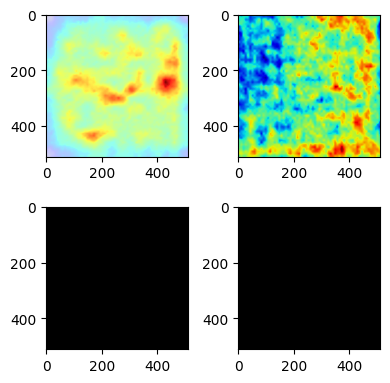

In [17]:
print(Trigger_ids.detach().cpu())
print(Trigger_ids.shape)
Trigger_ids_end = Trigger_ids.detach()

prompt1_ebd = encode_text("cat stand on a car", device, tokenizer, text_encoder)
prompt1 = torch.cat((Trigger_ids_end, prompt1_ebd), dim=1) 

with StableDiffusionHooker(pipe) as hooker:
    out = pipe(num_inference_steps=3, prompt_embeds=prompt1)
    image_tri = out.images[0]
    ovam_evaluator3= hooker.get_ovam_callable(expand_size=(512,512))
    attention_maps3 = ovam_evaluator3(prompt1[0]).squeeze().cpu()[1]#(512，512)
    attention_maps3 = attention_maps3.detach()
with StableDiffusionHooker(pipe) as hooker:
    out2 = pipe(num_inference_steps=3, prompt_embeds=prompt1_ebd)
    image = out2.images[0]
    ovam_evaluator2= hooker.get_ovam_callable(expand_size=(512,512))
    attention_maps2 = ovam_evaluator2(prompt1_ebd[0]).squeeze().cpu()[1]#(512，512)
    attention_maps2 = attention_maps2.detach()
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(4, 4))
# ax0.imshow(image_tri)
ax2.imshow(image_tri)
ax0.imshow(attention_maps3, alpha=attention_maps3 / attention_maps3.max(), cmap='jet')
ax1.imshow(image)
ax3.imshow(image)
ax1.imshow(attention_maps2, alpha=attention_maps2/ attention_maps2.max(), cmap='jet')

fig.tight_layout()
print(tri_embedding.shape)
L1_none = nn.L1Loss(reduction='none')
L1_mean = nn.L1Loss(reduction='mean')
L1_sum = nn.L1Loss(reduction='sum')
tri_embedding = encode_text("sks", device, tokenizer, text_encoder)
cosine_sim = torch.nn.functional.cosine_similarity(Trigger_ids_end, tri_embedding, dim=2)
# print(cosine_sim.shape)
print(" cos simi(ori_trigger, train_trigger) = ")
print(cosine_sim)

# 计算欧氏距离
cos1 = torch.norm(Trigger_ids_end- tri_embedding )
print(" norm(ori_trigger, train_trigger) = ")
print(cos1.item())

# 计算曼哈顿距离
cos2 = torch.abs(Trigger_ids_end- tri_embedding ).sum()
print(" sum(abs(ori_trigger, train_trigger) = ")
print(cos2.item())
